In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install glob
!pip install cv2
!pip install os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [ ]:
import tensorflow as tf
import segmentation_models as sm
import glob
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models

In [ ]:
backbone = "efficientnetb4" # the architecture 
preprocess_input = sm.get_preprocessing(backbone) # preprocessing
image_path = "/Users/owner/Dropbox/Mac/Desktop/sunflower field - Google Search"
images = [] # list of paths
width = 128
height = 128
channels = 3

# build the model:
inputs = tf.keras.layers.Input((width, height, channels))
c1 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal")
# tf.keras.layers.Conv2D()



In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
y_train = y_train.reshape(-1,)
classes = ["plane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
"""
cnn = models.Sequential([
    # cnn
    layers.Conv2D(filters=12, kernel_size=(3,3), activation="relu", input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=24, kernel_size=(3,3), activation="relu", input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    # dense
    layers.Flatten(input_shape=(32,32,3)),
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")]
)

cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
cnn.fit(x_train, y_train, epochs=10)
"""

'\ncnn = models.Sequential([\n    # cnn\n    layers.Conv2D(filters=12, kernel_size=(3,3), activation="relu", input_shape=(32,32,3)),\n    layers.MaxPooling2D((2,2)),\n    layers.Conv2D(filters=24, kernel_size=(3,3), activation="relu", input_shape=(32,32,3)),\n    layers.MaxPooling2D((2,2)),\n    # dense\n    layers.Flatten(input_shape=(32,32,3)),\n    layers.Dense(64, activation="relu"),\n    layers.Dense(10, activation="softmax")]\n)\n\ncnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])\ncnn.fit(x_train, y_train, epochs=10)\n'

In [ ]:
import json
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd

In [ ]:
# mount to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
class_dict = {'flower':1, 'background':0}
for i in range(1, 21, 1):
  with open(f'/content/drive/My Drive/AI_projects/ICRA_vision/labels/label{i}.json', 'r') as f:
    json_file = f'/content/drive/My Drive/AI_projects/ICRA_vision/labels/label{i}.json'
    all_labels = json.load(open(json_file))

print(all_labels.keys())
"""

In [ ]:
class_dict = {'flower':1, 'background':0} #dictionary of classes
json_file = f'/content/drive/My Drive/AI_projects/ICRA_vision/annotation/label20.json' #json file
all_labels = json.load(open(json_file))

In [ ]:
with open(json_file, "r") as f:
  data = json.load(f)

In [ ]:
def find_x(input):
  """
  returns a list of x coordinates
  """
  arr = np.array(input)
  x_ind = [i for i in range(len(input)) if i%2==0]
  x = list(arr[x_ind])
  return x

def find_y(input):
  """
  returns a list of y coordinates
  """
  arr = np.array(input)
  y_ind = [i for i in range(len(input)) if i%2==1]
  y = list(arr[y_ind])
  return y

In [ ]:
def get_image_files(data):
  images = []
  for d in data["images"]:
    image = d["file_name"]
    images.append(image)
  return images

In [ ]:
def get_coords(data):
  """
  returns 2 lists of x and y coordinates
  """
  x_list = []; y_list = []
  for d in data["annotations"]:
    for s in d["segmentation"]:
      x, y = find_x(s), find_y(s)
      x_list.append(x)
      y_list.append(y)
  return y_list, x_list #image coordinates are flipped relative to json coordinates

In [ ]:
x_coords, y_coords = get_coords(data)
images = get_image_files(data)

In [ ]:
from PIL import Image, ImageDraw

In [ ]:
"""
mask = np.zeros((nx, ny))

for i, j in zip(x_coords, y_coords):
  # the ImageDraw.Draw().polygon function we will use to create the mask requires the x's and y's are interweaved.
  polygon = np.vstack((j,i)).reshape((-1,), order='F').tolist()
  print(polygon)
  """

In [ ]:
a = [1,2,3,4]
b = [-1,-2,-3,-4]
#print(np.vstack((a,b)).reshape((-1,)))
#trans = list(np.vstack((a,b)).reshape((-1,), order='F'))
tuples = []
for i, j in zip(a, b):
  tuples.append((i,j))
tuples


[(1, -1), (2, -2), (3, -3), (4, -4)]

In [ ]:
def get_mask(x, y, nx, ny, class_dict):
    # get the dimensions of the image
    mask = np.zeros((nx, ny))

    polygon = []
    for j, i in zip(x, y):
      polygon.append((j,i))

    for y, x in zip(x, y):
      # the ImageDraw.Draw().polygon function we will use to create the mask requires the x's and y's are interweaved.
      # polygon = np.vstack((x,y)).reshape((-1,), order='F').tolist()
      # create a mask image of the right size and infill according to the polygon
      """
      if nx > ny:
        x, y = y, x
        img = Image.new('L', (nx, ny), 0)
      elif ny > nx:
        #x,y = y,x
        img = Image.new('L', (ny, nx), 0)
      else:
      """  
      img = Image.new('L', (nx, ny), 0)

      ImageDraw.Draw(img).polygon(polygon, outline=0, fill=1)
      # turn into a numpy array
      m = np.flipud(np.rot90(np.array(img)))
      try:
        mask[m==1] = 1
      except:
        mask[m.T==1] = 1
    return mask

In [ ]:
for image, x, y in zip(images, x_coords, y_coords):
  # x is a list of x_coords, y is a list of y_coords
  image = Image.open(f"/content/drive/My Drive/AI_projects/ICRA_vision/annotation/{image}")
  nx, ny, nz = np.shape(image)
  mask = get_mask(x, y, nx, ny, class_dict)
  print(mask)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

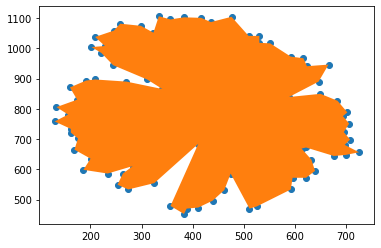

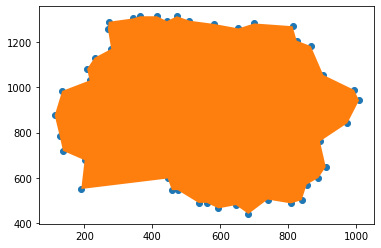

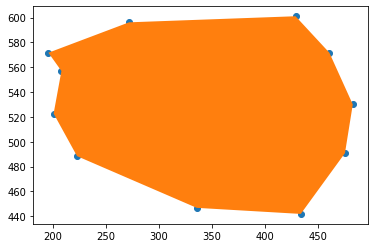

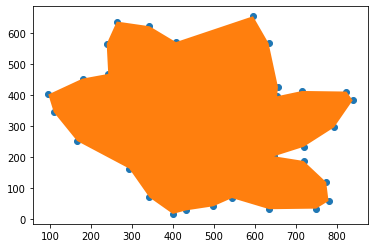

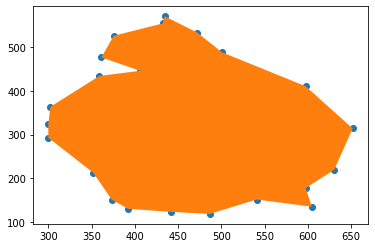

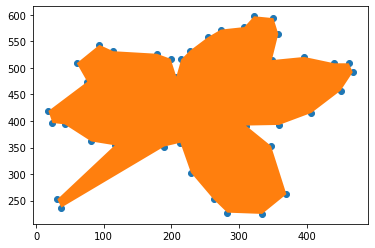

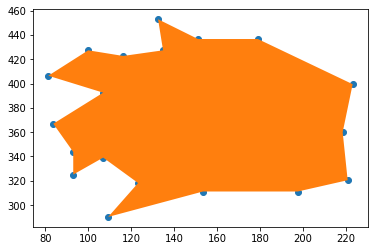

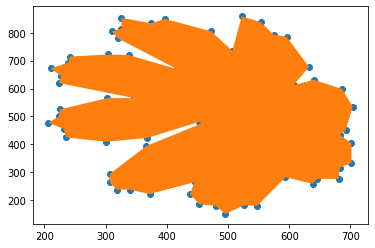

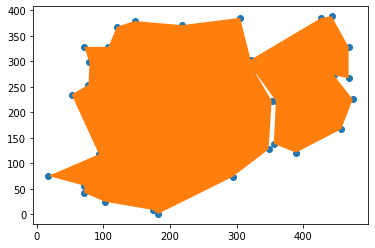

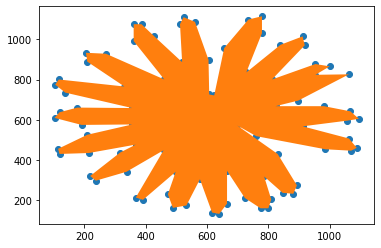

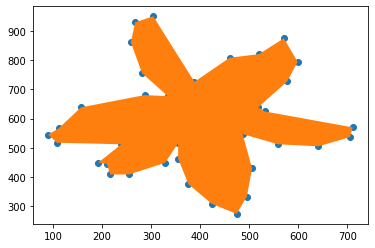

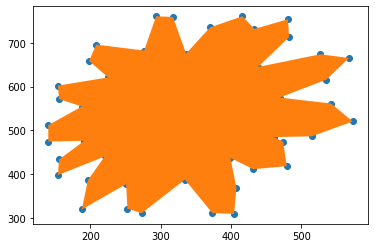

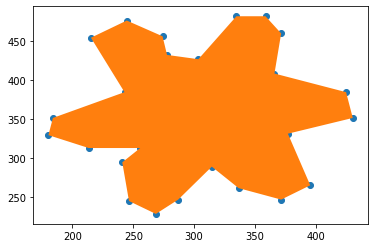

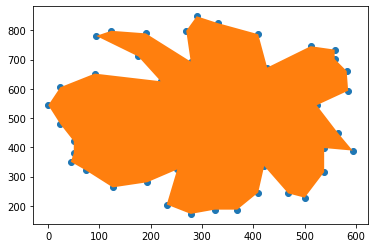

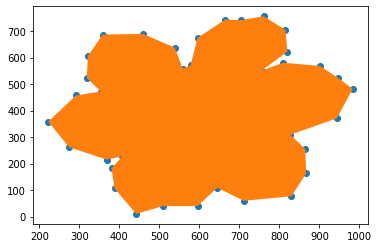

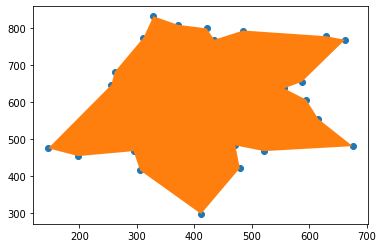

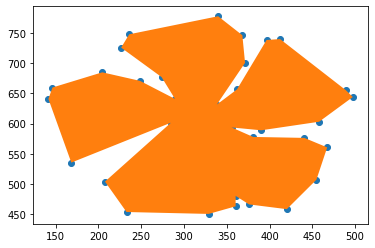

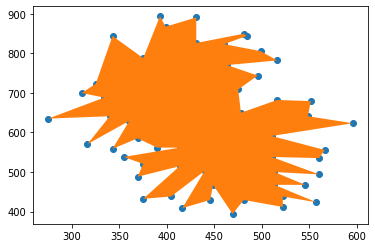

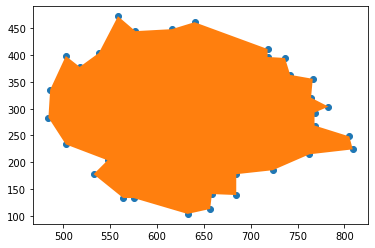

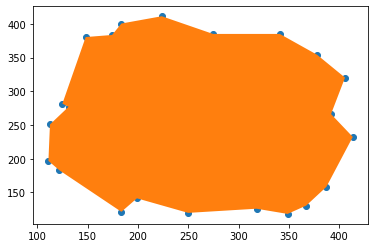

In [ ]:
from matplotlib import pyplot as plt


for x, y, image in zip(x_coords, y_coords, images):
  fig, ax = plt.subplots()
  ax.scatter(x, y)
  ax.fill(x, y)

In [ ]:
def rescale(dat, mn, mx):
    '''
    rescales an input dat between mn and mx
    '''
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

In [ ]:
for image, x, y in zip(images, x_coords, y_coords):
  raw = f"/content/drive/My Drive/AI_projects/ICRA_vision/annotation/{image}"
  image = Image.open(raw)
  nx, ny, nz = np.shape(image)
  mask = get_mask(x, y, nx, ny, class_dict)
  mask = Image.fromarray(rescale(mask, 0, 350)).convert('L')
  mask.save(raw.replace('.png','_label.png'), format='PNG')

In [ ]:

!git clone https://github.com/matterport/Mask_RCNN.git
cd Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 30.21 MiB/s, done.
Resolving deltas: 100% (565/565), done.


/content/Mask_RCNN


In [ ]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob

In [ ]:
image_directory = "/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw"
mask_directory = "/content/drive/My Drive/AI_projects/ICRA_vision/annotation/masks"

In [ ]:
image_names = glob.glob("/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/*.png")
image_names

['/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/Screen Shot 2022-06-30 at 1.57.09 PM.png',
 '/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/Screen Shot 2022-06-30 at 10.28.13 AM.png',
 '/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/Screen Shot 2022-06-30 at 10.28.38 AM.png',
 '/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/Screen Shot 2022-06-30 at 1.58.30 PM.png',
 '/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/Screen Shot 2022-06-30 at 11.03.30 AM.png',
 '/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/Screen Shot 2022-06-30 at 2.01.28 PM.png',
 '/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/Screen Shot 2022-06-30 at 2.01.59 PM.png',
 '/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/Screen Shot 2022-06-30 at 1.57.34 PM.png',
 '/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw/Screen Shot 2022-06-30 at 10.32.15 AM.png',
 '/content/drive/My Driv

In [ ]:
f2 = '/content/drive/My Drive/AI_projects/ICRA_vision/annotation/raw'

def resize_image(file):
  for f_img in images:
    raw = f"/content/drive/My Drive/AI_projects/ICRA_vision/annotation/{image}"
    img = Image.open(raw)
    img = img.resize((1200,1200))
    img.save(f_img)

resize_image(f2)

TypeError: ignored

In [ ]:
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [ ]:
mask_names = glob.glob("/content/drive/My Drive/AI_projects/ICRA_vision/annotation/masks/*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (20, 1)
Mask data shape is:  (20, 1)


ValueError: ignored

In [ ]:
num_images = 20
image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 1)

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/data/mitochondria/mito256x256/masks/*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
"""
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model
"""